In [611]:
!pip3 install pmdarima

In [612]:
# Import package
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings 
from statsmodels.tsa.api import SimpleExpSmoothing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error 
from datetime import datetime
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf


warnings.simplefilter('ignore')

In [613]:
data = pd.read_csv('Dataset1_global_mean_temp.csv',names = ['global_mean_temp'])


**Applying KPSS and ADF test**

1. ADF test

In [614]:
#define function for ADF test
from statsmodels.tsa.stattools import adfuller

def adf_test(atr):
    #Perform Dickey-Fuller test:
    timeseries = data[atr].dropna()
    print ('Results of Dickey-Fuller Test for ',atr,'\n')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

#apply adf test on the series
adf_test('global_mean_temp')

Results of Dickey-Fuller Test for  global_mean_temp 

Test Statistic                   0.330692
p-value                          0.978710
#Lags Used                       3.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


2. KPSS test

In [615]:
#define function for kpss test
from statsmodels.tsa.stattools import kpss
#define KPSS
def kpss_test(atr):
    timeseries = data[atr].dropna()
    print ('Results of KPSS Test for ',atr)
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
kpss_test('global_mean_temp')

Results of KPSS Test for  global_mean_temp
Test Statistic            0.937789
p-value                   0.010000
Lags Used                13.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


For ADF test, we can see that the p-value  is 0.978710, which is more than 0.05. Thus, from ADF test, we can say that the dataset is non-stationary.

For KPSS test, Test Statistic is more than Critical Value, thus we reject the null hypothesis. Thus, from KPSS test, we can say that the dataset is non-stationary.

Since, both tests conclude that the series is stationary, therefore, the dataset is concluded as Non-Stationary.



---



Making dataset stationary with differencing


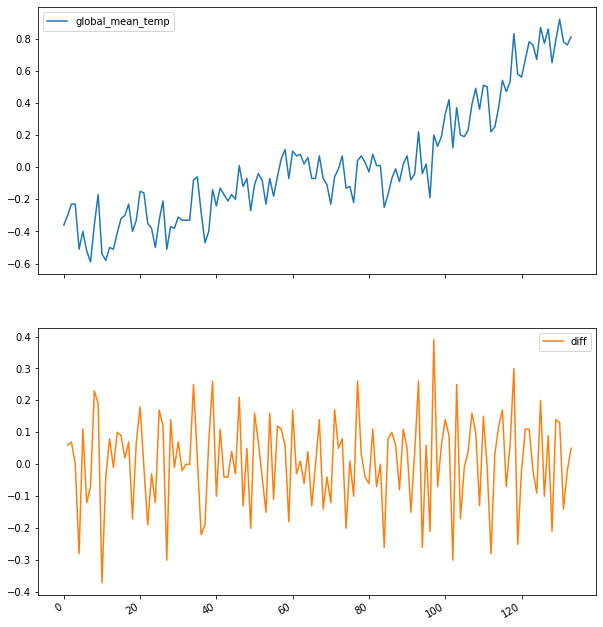

In [616]:
# Differencing
data['diff'] = data['global_mean_temp'].diff(periods=1)

data.plot(subplots=True, figsize=(10,12))
plt.show()



---



Applying Exponential Smoothening

In [617]:
#List of least mse and mae
mseses=[]
msedes=[]
msetes=[]
maeses=[]
maedes=[]
maetes=[]

**Single Exponential Smoothing**

In [618]:
#Defining Single Exponential Smoothing function ses
def ses(arr,alpha):
    arr1 = [arr[0]]
    for i in range(1, len(arr)):
        arr1.append(alpha * arr[i-1] + (1 - alpha) * arr1[i-1])
    return arr1

In [619]:
#Defining Mean of Squared Error Function mse
def mse(arr1,arr2):
  arr3=[0]
  for i, j in zip(arr1, arr2):
    arr3.append(i-j)
  Sum=0
  for i in arr3:
    sqr=i**2
    Sum+=sqr
  mse=Sum/(len(arr2)-1)
  return mse

In [620]:
#Function to make list of demand with interval 'n'
def dem_n(arr,n):
  arr1=[arr[0]]
  for i in range(1,len(arr)):
    if i%n==0:  
      arr1.append(arr[i])
  return arr1

In [621]:
#Creating demand list in 'n' intervals
demand=dem_n(data.global_mean_temp,1)

In [622]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

forecast1=ses(demand,alpha1)
forecast2=ses(demand,alpha2)
forecast3=ses(demand,alpha3)

In [623]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8 is: ",mse3)

Mean of Square Errors for alpha = 0.2 is:  0.017627575897166053
Mean of Square Errors for alpha = 0.5 is:  0.01617131015410465
Mean of Square Errors for alpha = 0.8 is:  0.017968676960481184


In [624]:
#Calculating Mean Absolute Errors
mae1=mean_absolute_error(demand,forecast1)
mae2=mean_absolute_error(demand,forecast2)
mae3=mean_absolute_error(demand,forecast3)

print("Mean Absolute Errors for alpha = 0.2 is: ",mae1)
print("Mean Absolute Errors for alpha = 0.5 is: ",mae2)
print("Mean Absolute Errors for alpha = 0.8 is: ",mae3)

Mean Absolute Errors for alpha = 0.2 is:  0.10751676957671709
Mean Absolute Errors for alpha = 0.5 is:  0.10363842544836274
Mean Absolute Errors for alpha = 0.8 is:  0.10754580488424474


alpha:  0.5


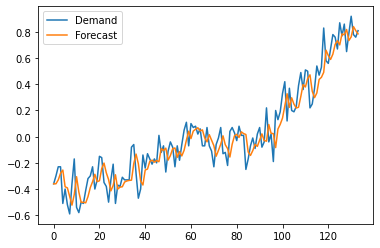

In [625]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  df1.plot(style=['-','-'])
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  df2.plot(style=['-','-'])
else:
  print('alpha: ',alpha3)
  df3.plot(style=['-','-'])


**Double Exponential Smoothing**

In [626]:
#Defining Double Exponential Smoothing function des
def des(arr,alpha,beta):
  a=[arr[0]]
  l=len(arr)
  b=[(arr[l-1]-arr[0])/(l-1)]
  arr1 = [arr[0]]
  arr1.append(a[0]+b[0])
  for i in range(1,len(arr)-1):
      a.append(alpha * arr[i] + (1 - alpha) * (a[i-1]+b[i-1]))
      b.append(beta * (a[i]-a[i-1]) + (1 - beta) * (b[i-1]))        
      arr1.append(a[i]+b[i])
  return arr1

In [627]:
#Creating demand list in 'n' intervals
demand=dem_n(data.global_mean_temp,1)

In [628]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

forecast1=des(demand,alpha1,beta1)
forecast2=des(demand,alpha2,beta2)
forecast3=des(demand,alpha3,beta3)

In [629]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 is:  0.017968472190272575
Mean of Square Errors for alpha = 0.5,beta= 0.6 is:  0.023665107048017036
Mean of Square Errors for alpha = 0.8,beta= 0.9 is:  0.03558094712785075


In [630]:
#Calculating Mean Absolute Errors
mae1=mean_absolute_error(demand,forecast1)
mae2=mean_absolute_error(demand,forecast2)
mae3=mean_absolute_error(demand,forecast3)

print("Mean Absolute Errors for alpha = 0.2,beta= 0.3 is: ",mae1)
print("Mean Absolute Errors for alpha = 0.5,beta= 0.6 is: ",mae2)
print("Mean Absolute Errors for alpha = 0.8,beta= 0.9 is: ",mae3)

Mean Absolute Errors for alpha = 0.2,beta= 0.3 is:  0.10647490064149882
Mean Absolute Errors for alpha = 0.5,beta= 0.6 is:  0.12040883049870627
Mean Absolute Errors for alpha = 0.8,beta= 0.9 is:  0.14733969382416773


alpha:  0.2
beta:  0.3


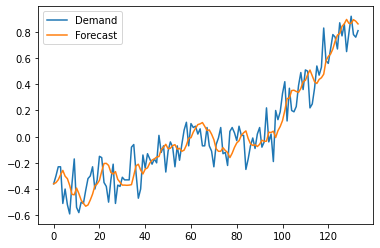

In [631]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  df1.plot(style=['-','-'])
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  df2.plot(style=['-','-'])
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  df3.plot(style=['-','-'])

**Triple Exponential Smoothing**

In [632]:
#Defining initial trend
def initial_trend(arr, slen):
    Sum = 0
    for i in range(slen):
        Sum += float(arr[i+slen] - arr[i]) / slen
    return Sum / slen

In [633]:
#Defining initial seasonal
def initial_seasonal(arr, slen):
    arr1 = {}
    s_avg = []
    m = int(len(arr)/slen)
    for j in range(m):
        s_avg.append(sum(arr[slen*j:slen*j+slen])/float(slen))
    for i in range(slen):
        Sum = 0
        for j in range(m):
            Sum += arr[slen*j+i]-s_avg[j]
        arr1[i] = Sum/m
    return arr1

In [634]:
#Defining Triple Exponential Smoothing function tes with interval 'n'
def tes(arr, slen, alpha, beta, gamma, n):
    arr1 = []
    seasonals = initial_seasonal(arr, slen)
    for i in range(len(arr)+n):
        if i == 0:
            smooth = arr[0]
            trend = initial_trend(arr, slen)
            arr1.append(arr[0])
            continue
        if i >= len(arr):
            m = i - len(arr) + 1
            arr1.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = arr[i]
            lsmooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-lsmooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            arr1.append(smooth+trend+seasonals[i%slen])
    return arr1

In [635]:
#Creating demand list in 'n' intervals
demand=dem_n(data.global_mean_temp,1)

In [636]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

gamma1=0.4
gamma2=0.7
gamma3=0.95

#Considering season of 1 hours here

forecast1=tes(demand,1,alpha1,beta1,gamma1,0)
forecast2=tes(demand,1,alpha2,beta2,gamma2,0)
forecast3=tes(demand,1,alpha3,beta3,gamma3,0)

In [637]:
#Calculating mean of sqaured errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is:  0.004115481353097386
Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is:  0.0010619297688366797
Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is:  0.0087458931387771


In [638]:
#Calculating Mean Absolute Errors
mae1=mean_absolute_error(demand,forecast1)
mae2=mean_absolute_error(demand,forecast2)
mae3=mean_absolute_error(demand,forecast3)

print("Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is: ",mae1)
print("Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is: ",mae2)
print("Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is: ",mae3)

Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is:  0.05096165897173092
Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is:  0.026609223640182905
Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is:  0.07517010749800324


alpha:  0.5
beta:  0.6
gamma:  0.7


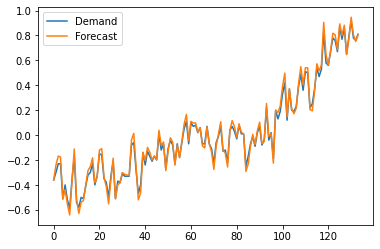

In [639]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  print('gamma: ',gamma1)
  df1.plot(style=['-','-'])
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  print('gamma: ',gamma2)
  df2.plot(style=['-','-'])
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  print('gamma: ',gamma3)
  df3.plot(style=['-','-'])



---



For 1 Unit

**Single Exponential Smoothing**

In [640]:
#Creating demand list in 'n' intervals
demand=dem_n(data.global_mean_temp,1)

In [641]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

forecast1=ses(demand,alpha1)
forecast2=ses(demand,alpha2)
forecast3=ses(demand,alpha3)

In [642]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8 is: ",mse3)

Mean of Square Errors for alpha = 0.2 is:  0.017627575897166053
Mean of Square Errors for alpha = 0.5 is:  0.01617131015410465
Mean of Square Errors for alpha = 0.8 is:  0.017968676960481184


alpha:  0.5


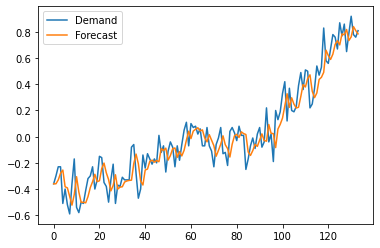

In [643]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  df1.plot(style=['-','-'])
  mseses.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  df2.plot(style=['-','-'])
  mseses.append(mse2) 
else:
  print('alpha: ',alpha3)
  df3.plot(style=['-','-'])
  mseses.append(mse3)

In [644]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maeses.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maeses.append(mae2)
else:
  maeses.append(mae3)

**Double Exponential Smoothing**

In [645]:
#Creating demand list in 'n' intervals
demand=dem_n(data.global_mean_temp,1)

In [646]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

forecast1=des(demand,alpha1,beta1)
forecast2=des(demand,alpha2,beta2)
forecast3=des(demand,alpha3,beta3)

In [647]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 is:  0.017968472190272575
Mean of Square Errors for alpha = 0.5,beta= 0.6 is:  0.023665107048017036
Mean of Square Errors for alpha = 0.8,beta= 0.9 is:  0.03558094712785075


alpha:  0.2
beta:  0.3


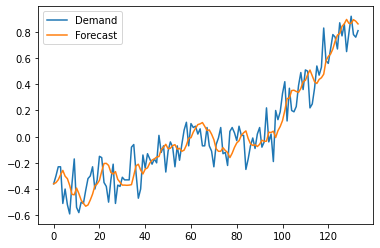

In [648]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  df1.plot(style=['-','-'])
  msedes.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  df2.plot(style=['-','-'])
  msedes.append(mse2) 
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  df3.plot(style=['-','-'])
  msedes.append(mse3)

In [649]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maedes.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maedes.append(mae2)
else:
  maedes.append(mae3)

**Triple Exponential Smoothing**

In [650]:
#Creating demand list in 'n' intervals
demand=dem_n(data.global_mean_temp,1)

In [651]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

gamma1=0.4
gamma2=0.7
gamma3=0.95

#Considering season of 1 hours here

forecast1=tes(demand,1,alpha1,beta1,gamma1,0)
forecast2=tes(demand,1,alpha2,beta2,gamma2,0)
forecast3=tes(demand,1,alpha3,beta3,gamma3,0)

In [652]:
#Calculating mean of sqaured errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is:  0.004115481353097386
Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is:  0.0010619297688366797
Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is:  0.0087458931387771


In [653]:
#Calculating Mean Absolute Errors
mae1=mean_absolute_error(demand,forecast1)
mae2=mean_absolute_error(demand,forecast2)
mae3=mean_absolute_error(demand,forecast3)

print("Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is: ",mae1)
print("Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is: ",mae2)
print("Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is: ",mae3)

Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is:  0.05096165897173092
Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is:  0.026609223640182905
Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is:  0.07517010749800324


alpha:  0.5
beta:  0.6
gamma:  0.7


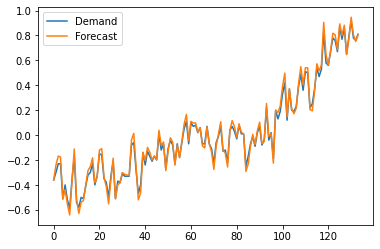

In [654]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  print('gamma: ',gamma1)
  df1.plot(style=['-','-'])
  msetes.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  print('gamma: ',gamma2)
  df2.plot(style=['-','-'])
  msetes.append(mse2) 
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  print('gamma: ',gamma3)
  df3.plot(style=['-','-'])
  msetes.append(mse3)

In [655]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maetes.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maetes.append(mae2)
else:
  maetes.append(mae3)

For 2 Unit

**Single Exponential Smoothing**

In [656]:
#Creating demand list in 'n' intervals
demand=dem_n(data.global_mean_temp,2)

In [657]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

forecast1=ses(demand,alpha1)
forecast2=ses(demand,alpha2)
forecast3=ses(demand,alpha3)

In [658]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8 is: ",mse3)

Mean of Square Errors for alpha = 0.2 is:  0.028057403955295324
Mean of Square Errors for alpha = 0.5 is:  0.02035445919597396
Mean of Square Errors for alpha = 0.8 is:  0.022901086822187305


alpha:  0.5


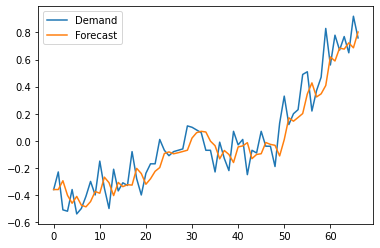

In [659]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  df1.plot(style=['-','-'])
  mseses.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  df2.plot(style=['-','-'])
  mseses.append(mse2) 
else:
  print('alpha: ',alpha3)
  df3.plot(style=['-','-'])
  mseses.append(mse3)

In [660]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maeses.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maeses.append(mae2)
else:
  maeses.append(mae3)

**Double Exponential Smoothing**

In [661]:
#Creating demand list in 'n' intervals
demand=dem_n(data.global_mean_temp,2)

In [662]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

forecast1=des(demand,alpha1,beta1)
forecast2=des(demand,alpha2,beta2)
forecast3=des(demand,alpha3,beta3)

In [663]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 is:  0.01999545954388405
Mean of Square Errors for alpha = 0.5,beta= 0.6 is:  0.026251623176574396
Mean of Square Errors for alpha = 0.8,beta= 0.9 is:  0.04539202303859103


alpha:  0.2
beta:  0.3


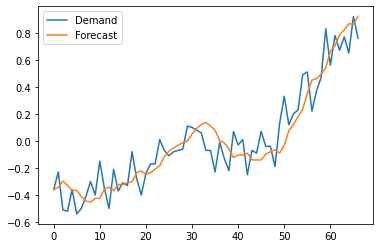

In [664]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  df1.plot(style=['-','-'])
  msedes.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  df2.plot(style=['-','-'])
  msedes.append(mse2) 
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  df3.plot(style=['-','-'])
  msedes.append(mse3)

In [665]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maedes.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maedes.append(mae2)
else:
  maedes.append(mae3)

**Triple Exponential Smoothing**

In [666]:
#Creating demand list in 'n' intervals
demand=dem_n(data.global_mean_temp,2)

In [667]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

gamma1=0.4
gamma2=0.7
gamma3=0.95

#Considering season of 1 hours here

forecast1=tes(demand,1,alpha1,beta1,gamma1,0)
forecast2=tes(demand,1,alpha2,beta2,gamma2,0)
forecast3=tes(demand,1,alpha3,beta3,gamma3,0)

In [668]:
#Calculating mean of sqaured errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is:  0.008236314412753888
Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is:  0.0016388047846092593
Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is:  0.010997893163717798


In [669]:
#Calculating Mean Absolute Errors
mae1=mean_absolute_error(demand,forecast1)
mae2=mean_absolute_error(demand,forecast2)
mae3=mean_absolute_error(demand,forecast3)

print("Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is: ",mae1)
print("Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is: ",mae2)
print("Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is: ",mae3)

Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is:  0.06932163770874376
Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is:  0.03133931987936451
Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is:  0.08426318449948132


alpha:  0.5
beta:  0.6
gamma:  0.7


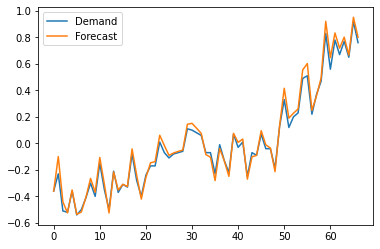

In [670]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  print('gamma: ',gamma1)
  df1.plot(style=['-','-'])
  msetes.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  print('gamma: ',gamma2)
  df2.plot(style=['-','-'])
  msetes.append(mse2) 
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  print('gamma: ',gamma3)
  df3.plot(style=['-','-'])
  msetes.append(mse3)

In [671]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maetes.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maetes.append(mae2)
else:
  maetes.append(mae3)

For 4 Unit

**Single Exponential Smoothing**

In [672]:
#Creating demand list in 'n' intervals
demand=dem_n(data.global_mean_temp,4)

In [673]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

forecast1=ses(demand,alpha1)
forecast2=ses(demand,alpha2)
forecast3=ses(demand,alpha3)

In [674]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8 is: ",mse3)

Mean of Square Errors for alpha = 0.2 is:  0.04595174517032602
Mean of Square Errors for alpha = 0.5 is:  0.025889497431882152
Mean of Square Errors for alpha = 0.8 is:  0.026282815521385526


alpha:  0.5


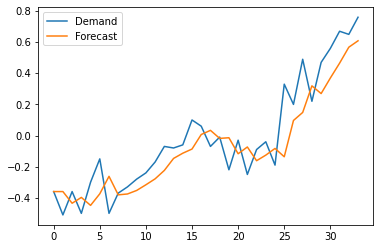

In [675]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  df1.plot(style=['-','-'])
  mseses.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  df2.plot(style=['-','-'])
  mseses.append(mse2) 
else:
  print('alpha: ',alpha3)
  df3.plot(style=['-','-'])
  mseses.append(mse3)

In [676]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maeses.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maeses.append(mae2)
else:
  maeses.append(mae3)

**Double Exponential Smoothing**

In [677]:
#Creating demand list in 'n' intervals
demand=dem_n(data.global_mean_temp,4)

In [678]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

forecast1=des(demand,alpha1,beta1)
forecast2=des(demand,alpha2,beta2)
forecast3=des(demand,alpha3,beta3)

In [679]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 is:  0.031130343809725954
Mean of Square Errors for alpha = 0.5,beta= 0.6 is:  0.025086948873225354
Mean of Square Errors for alpha = 0.8,beta= 0.9 is:  0.046265818205273715


alpha:  0.5
beta:  0.6


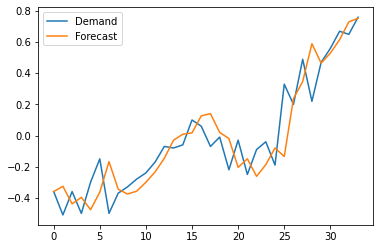

In [680]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  df1.plot(style=['-','-'])
  msedes.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  df2.plot(style=['-','-'])
  msedes.append(mse2) 
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  df3.plot(style=['-','-'])
  msedes.append(mse3)

In [681]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maedes.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maedes.append(mae2)
else:
  maedes.append(mae3)

**Triple Exponential Smoothing**

In [682]:
#Creating demand list in 'n' intervals
demand=dem_n(data.global_mean_temp,4)

In [683]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

gamma1=0.4
gamma2=0.7
gamma3=0.95

#Considering season of 1 hours here

forecast1=tes(demand,1,alpha1,beta1,gamma1,0)
forecast2=tes(demand,1,alpha2,beta2,gamma2,0)
forecast3=tes(demand,1,alpha3,beta3,gamma3,0)

In [684]:
#Calculating mean of sqaured errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is:  0.01514477148242445
Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is:  0.003449731691962658
Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is:  0.012850622128417841


In [685]:
#Calculating Mean Absolute Errors
mae1=mean_absolute_error(demand,forecast1)
mae2=mean_absolute_error(demand,forecast2)
mae3=mean_absolute_error(demand,forecast3)

print("Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is: ",mae1)
print("Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is: ",mae2)
print("Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is: ",mae3)

Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is:  0.09356505028570597
Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is:  0.047139660620951956
Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is:  0.08996675396865808


alpha:  0.5
beta:  0.6
gamma:  0.7


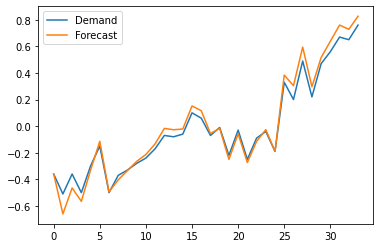

In [686]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  print('gamma: ',gamma1)
  df1.plot(style=['-','-'])
  msetes.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  print('gamma: ',gamma2)
  df2.plot(style=['-','-'])
  msetes.append(mse2) 
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  print('gamma: ',gamma3)
  df3.plot(style=['-','-'])
  msetes.append(mse3)

In [687]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maetes.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maetes.append(mae2)
else:
  maetes.append(mae3)

For 8 Unit

**Single Exponential Smoothing**

In [688]:
#Creating demand list in 'n' intervals
demand=dem_n(data.global_mean_temp,8)

In [689]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

forecast1=ses(demand,alpha1)
forecast2=ses(demand,alpha2)
forecast3=ses(demand,alpha3)

In [690]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8 is: ",mse3)

Mean of Square Errors for alpha = 0.2 is:  0.0661955638561374
Mean of Square Errors for alpha = 0.5 is:  0.03545046620342662
Mean of Square Errors for alpha = 0.8 is:  0.02617769649822023


alpha:  0.8


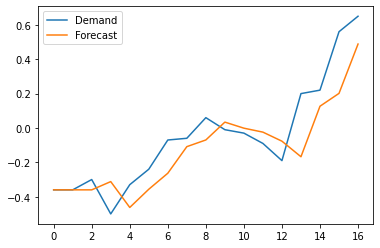

In [691]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  df1.plot(style=['-','-'])
  mseses.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  df2.plot(style=['-','-'])
  mseses.append(mse2) 
else:
  print('alpha: ',alpha3)
  df3.plot(style=['-','-'])
  mseses.append(mse3)

In [692]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maeses.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maeses.append(mae2)
else:
  maeses.append(mae3)

**Double Exponential Smoothing**

In [693]:
#Creating demand list in 'n' intervals
demand=dem_n(data.global_mean_temp,8)

In [694]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

forecast1=des(demand,alpha1,beta1)
forecast2=des(demand,alpha2,beta2)
forecast3=des(demand,alpha3,beta3)

In [695]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 is:  0.03366151460950395
Mean of Square Errors for alpha = 0.5,beta= 0.6 is:  0.03154046355796777
Mean of Square Errors for alpha = 0.8,beta= 0.9 is:  0.027693931545014937


alpha:  0.8
beta:  0.9


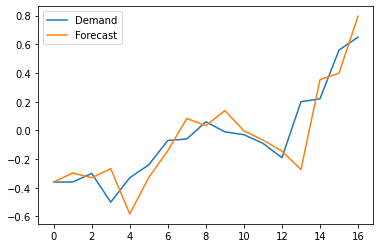

In [696]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  df1.plot(style=['-','-'])
  msedes.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  df2.plot(style=['-','-'])
  msedes.append(mse2) 
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  df3.plot(style=['-','-'])
  msedes.append(mse3)

In [697]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maedes.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maedes.append(mae2)
else:
  maedes.append(mae3)

**Triple Exponential Smoothing**

In [698]:
#Creating demand list in 'n' intervals
demand=dem_n(data.global_mean_temp,8)

In [699]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

gamma1=0.4
gamma2=0.7
gamma3=0.95

#Considering season of 1 hours here

forecast1=tes(demand,1,alpha1,beta1,gamma1,0)
forecast2=tes(demand,1,alpha2,beta2,gamma2,0)
forecast3=tes(demand,1,alpha3,beta3,gamma3,0)

In [700]:
#Calculating mean of sqaured errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is:  0.004245136804195677
Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is:  0.004016988867984858
Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is:  0.014150748017754799


In [701]:
#Calculating Mean Absolute Errors
mae1=mean_absolute_error(demand,forecast1)
mae2=mean_absolute_error(demand,forecast2)
mae3=mean_absolute_error(demand,forecast3)

print("Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is: ",mae1)
print("Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is: ",mae2)
print("Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is: ",mae3)

Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is:  0.05458128905756587
Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is:  0.04576964175516354
Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is:  0.09224994318817883


alpha:  0.5
beta:  0.6
gamma:  0.7


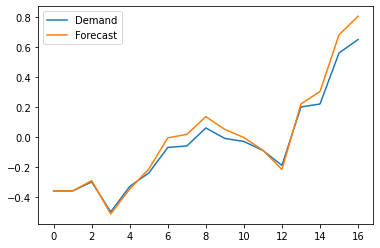

In [702]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  print('gamma: ',gamma1)
  df1.plot(style=['-','-'])
  msetes.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  print('gamma: ',gamma2)
  df2.plot(style=['-','-'])
  msetes.append(mse2) 
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  print('gamma: ',gamma3)
  df3.plot(style=['-','-'])
  msetes.append(mse3)

In [703]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maetes.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maetes.append(mae2)
else:
  maetes.append(mae3)

For 12 Unit

**Single Exponential Smoothing**

In [704]:
#Creating demand list in 'n' intervals
demand=dem_n(data.global_mean_temp,12)

In [705]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

forecast1=ses(demand,alpha1)
forecast2=ses(demand,alpha2)
forecast3=ses(demand,alpha3)

In [706]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8 is: ",mse3)

Mean of Square Errors for alpha = 0.2 is:  0.14439120293179095
Mean of Square Errors for alpha = 0.5 is:  0.08774129603703816
Mean of Square Errors for alpha = 0.8 is:  0.06776960314809816


alpha:  0.8


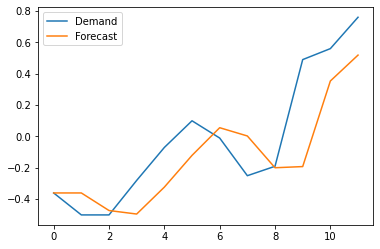

In [707]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  df1.plot(style=['-','-'])
  mseses.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  df2.plot(style=['-','-'])
  mseses.append(mse2) 
else:
  print('alpha: ',alpha3)
  df3.plot(style=['-','-'])
  mseses.append(mse3)

In [708]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maeses.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maeses.append(mae2)
else:
  maeses.append(mae3)

**Double Exponential Smoothing**

In [709]:
#Creating demand list in 'n' intervals
demand=dem_n(data.global_mean_temp,12)

In [710]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

forecast1=des(demand,alpha1,beta1)
forecast2=des(demand,alpha2,beta2)
forecast3=des(demand,alpha3,beta3)

In [711]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 is:  0.06896961923406343
Mean of Square Errors for alpha = 0.5,beta= 0.6 is:  0.08297600551033225
Mean of Square Errors for alpha = 0.8,beta= 0.9 is:  0.0924795098069323


alpha:  0.2
beta:  0.3


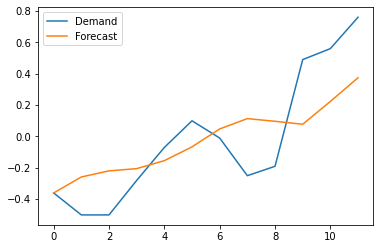

In [712]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  df1.plot(style=['-','-'])
  msedes.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  df2.plot(style=['-','-'])
  msedes.append(mse2) 
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  df3.plot(style=['-','-'])
  msedes.append(mse3)

In [713]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maedes.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maedes.append(mae2)
else:
  maedes.append(mae3)

**Triple Exponential Smoothing**

In [714]:
#Creating demand list in 'n' intervals
demand=dem_n(data.global_mean_temp,12)

In [715]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

gamma1=0.4
gamma2=0.7
gamma3=0.95

#Considering season of 1 hours here

forecast1=tes(demand,1,alpha1,beta1,gamma1,0)
forecast2=tes(demand,1,alpha2,beta2,gamma2,0)
forecast3=tes(demand,1,alpha3,beta3,gamma3,0)

In [716]:
#Calculating mean of sqaured errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is:  0.04382522920312487
Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is:  0.011070620993134666
Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is:  0.03782372844198626


In [717]:
#Calculating Mean Absolute Errors
mae1=mean_absolute_error(demand,forecast1)
mae2=mean_absolute_error(demand,forecast2)
mae3=mean_absolute_error(demand,forecast3)

print("Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is: ",mae1)
print("Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is: ",mae2)
print("Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is: ",mae3)

Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is:  0.17492533053808723
Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is:  0.08594612043585888
Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is:  0.14923404244967667


alpha:  0.5
beta:  0.6
gamma:  0.7


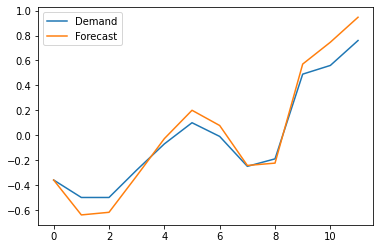

In [718]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  print('gamma: ',gamma1)
  df1.plot(style=['-','-'])
  msetes.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  print('gamma: ',gamma2)
  df2.plot(style=['-','-'])
  msetes.append(mse2) 
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  print('gamma: ',gamma3)
  df3.plot(style=['-','-'])
  msetes.append(mse3)

In [719]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maetes.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maetes.append(mae2)
else:
  maetes.append(mae3)

For 24 Interval

**Single Exponential Smoothing**

In [720]:
#Creating demand list in 'n' intervals
demand=dem_n(data.global_mean_temp,24)

In [721]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

forecast1=ses(demand,alpha1)
forecast2=ses(demand,alpha2)
forecast3=ses(demand,alpha3)

In [722]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8 is: ",mse3)

Mean of Square Errors for alpha = 0.2 is:  0.1460473568426667
Mean of Square Errors for alpha = 0.5 is:  0.12146666666666668
Mean of Square Errors for alpha = 0.8 is:  0.12364050564266665


alpha:  0.5


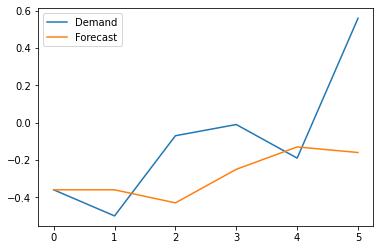

In [723]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  df1.plot(style=['-','-'])
  mseses.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  df2.plot(style=['-','-'])
  mseses.append(mse2) 
else:
  print('alpha: ',alpha3)
  df3.plot(style=['-','-'])
  mseses.append(mse3)

In [724]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maeses.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maeses.append(mae2)
else:
  maeses.append(mae3)

**Double Exponential Smoothing**

In [725]:
#Creating demand list in 'n' intervals
demand=dem_n(data.global_mean_temp,24)

In [726]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

forecast1=des(demand,alpha1,beta1)
forecast2=des(demand,alpha2,beta2)
forecast3=des(demand,alpha3,beta3)

In [727]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 is:  0.061580160134174604
Mean of Square Errors for alpha = 0.5,beta= 0.6 is:  0.08896061492949336
Mean of Square Errors for alpha = 0.8,beta= 0.9 is:  0.17058349780417123


alpha:  0.2
beta:  0.3


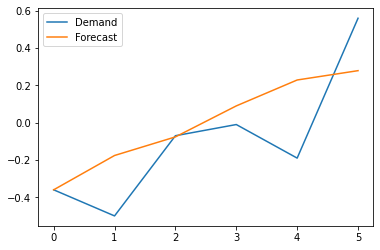

In [728]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  df1.plot(style=['-','-'])
  msedes.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  df2.plot(style=['-','-'])
  msedes.append(mse2) 
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  df3.plot(style=['-','-'])
  msedes.append(mse3)

**Triple Exponential Smoothing**

In [729]:
#Creating demand list in 'n' intervals
demand=dem_n(data.global_mean_temp,24)

In [730]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

gamma1=0.4
gamma2=0.7
gamma3=0.95

#Considering season of 1 hours here

forecast1=tes(demand,1,alpha1,beta1,gamma1,0)
forecast2=tes(demand,1,alpha2,beta2,gamma2,0)
forecast3=tes(demand,1,alpha3,beta3,gamma3,0)

In [731]:
#Calculating mean of sqaured errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is:  0.07630571317837302
Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is:  0.0061379864648235674
Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is:  0.0610634506977876


In [732]:
#Calculating Mean Absolute Errors
mae1=mean_absolute_error(demand,forecast1)
mae2=mean_absolute_error(demand,forecast2)
mae3=mean_absolute_error(demand,forecast3)

print("Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is: ",mae1)
print("Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is: ",mae2)
print("Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is: ",mae3)

Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is:  0.22936229786666665
Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is:  0.06308794791666666
Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is:  0.18760887805000004


alpha:  0.5
beta:  0.6
gamma:  0.7


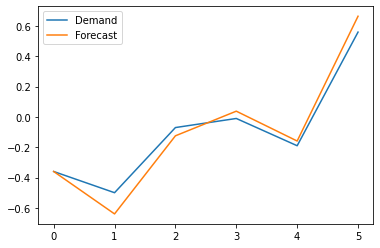

In [733]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  print('gamma: ',gamma1)
  df1.plot(style=['-','-'])
  msetes.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  print('gamma: ',gamma2)
  df2.plot(style=['-','-'])
  msetes.append(mse2) 
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  print('gamma: ',gamma3)
  df3.plot(style=['-','-'])
  msetes.append(mse3)

In [734]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maetes.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maetes.append(mae2)
else:
  maetes.append(mae3)



---

Least MSE and MAE values are


In [735]:
print("Least MSE ses")
print(mseses)
print("Least MSE des")
print(msedes)
print("Least MSE tes")
print(msetes)


print("Least MAE ses")
print(maeses)
print("Least MAE des")
print(maedes)
print("Least MAE tes")
print(maetes)


Least MSE ses
[0.01617131015410465, 0.02035445919597396, 0.025889497431882152, 0.02617769649822023, 0.06776960314809816, 0.12146666666666668]
Least MSE des
[0.017968472190272575, 0.01999545954388405, 0.025086948873225354, 0.027693931545014937, 0.06896961923406343, 0.061580160134174604]
Least MSE tes
[0.0010619297688366797, 0.0016388047846092593, 0.003449731691962658, 0.004016988867984858, 0.011070620993134666, 0.0061379864648235674]
Least MAE ses
[0.026609223640182905, 0.026609223640182905, 0.03133931987936451, 0.047139660620951956, 0.04576964175516354, 0.08594612043585888]
Least MAE des
[0.026609223640182905, 0.026609223640182905, 0.03133931987936451, 0.047139660620951956, 0.04576964175516354]
Least MAE tes
[0.026609223640182905, 0.03133931987936451, 0.047139660620951956, 0.04576964175516354, 0.08594612043585888, 0.06308794791666666]




---



Applying ACF and PACF

<function matplotlib.pyplot.show>

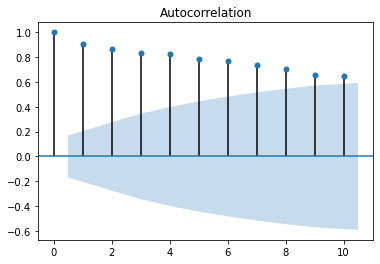

In [736]:
#Plotting ACF
plot_acf(data.global_mean_temp,lags=10)
plt.show

<function matplotlib.pyplot.show>

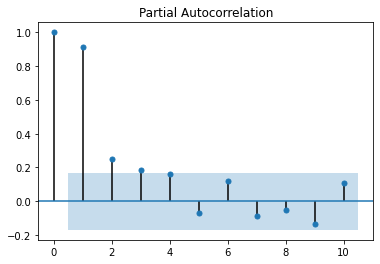

In [737]:
#plotting PACF
plot_pacf(data.global_mean_temp,lags=10)
plt.show



---



Applying AR, MA, ARIMA Models

                              ARMA Model Results                              
Dep. Variable:       global_mean_temp   No. Observations:                  134
Model:                     ARMA(1, 0)   Log Likelihood                  72.131
Method:                       css-mle   S.D. of innovations              0.140
Date:                Mon, 01 Mar 2021   AIC                           -138.261
Time:                        04:44:23   BIC                           -129.568
Sample:                             0   HQIC                          -134.728
                                                                              
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0527      0.175      0.302      0.763      -0.289       0.395
ar.L1.global_mean_temp     0.9370      0.031     29.937      0.000       0.876       0.998
    

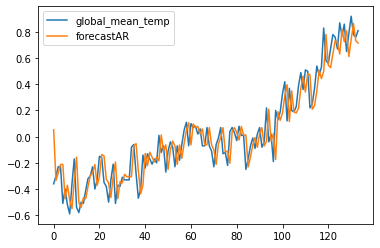

In [738]:
#AR

#fit model
model=ARIMA(data['global_mean_temp'], order=(1,0,0))
model_fit=model.fit()

#model summary
print(model_fit.summary())

#make prediction
data['forecastAR'] = model_fit.predict()
data[['global_mean_temp','forecastAR']].plot()

In [741]:
mse=mean_squared_error(data.global_mean_temp,data.forecastAR.dropna())
print("MSE for AR is:",mse)

MSE for AR is: 0.02075665468619131


In [743]:
mae=mean_absolute_error(data.global_mean_temp,data.forecastAR.dropna())
print("MAE for AR is:",mae)

MAE for AR is: 0.11471516004965322


                              ARMA Model Results                              
Dep. Variable:       global_mean_temp   No. Observations:                  134
Model:                     ARMA(0, 2)   Log Likelihood                  26.824
Method:                       css-mle   S.D. of innovations              0.197
Date:                Mon, 01 Mar 2021   AIC                            -45.647
Time:                        04:45:00   BIC                            -34.056
Sample:                             0   HQIC                           -40.937
                                                                              
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0187      0.043      0.430      0.668      -0.066       0.104
ma.L1.global_mean_temp     0.9872      0.075     13.240      0.000       0.841       1.133
ma.L

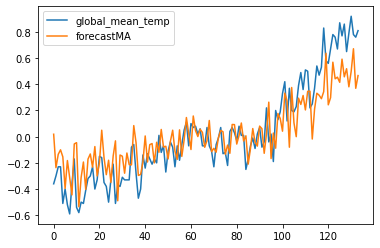

In [744]:
#MA

#fit model
model=ARIMA(data['global_mean_temp'].dropna(), order=(0,0,2))
model_fit=model.fit()

#model summary
print(model_fit.summary())

#make prediction
data['forecastMA'] = model_fit.predict()
data[['global_mean_temp','forecastMA']].plot()

In [746]:
mse=mean_squared_error(data.global_mean_temp,data.forecastMA.dropna())
print("MSE for MA is:",mse)

MSE for MA is: 0.039539084324022956


In [747]:
mae=mean_absolute_error(data.global_mean_temp,data.forecastMA.dropna())
print("MAE for MA is:",mae)

MAE for MA is: 0.15743063176569777


                             ARIMA Model Results                              
Dep. Variable:                 D.diff   No. Observations:                  132
Model:                 ARIMA(0, 1, 2)   Log Likelihood                  85.246
Method:                       css-mle   S.D. of innovations              0.123
Date:                Mon, 01 Mar 2021   AIC                           -162.493
Time:                        05:08:19   BIC                           -150.961
Sample:                             1   HQIC                          -157.807
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0002   7.94e-05      2.031      0.042    5.65e-06       0.000
ma.L1.D.diff    -1.7309      0.079    -21.779      0.000      -1.887      -1.575
ma.L2.D.diff     0.7310      0.078      9.41

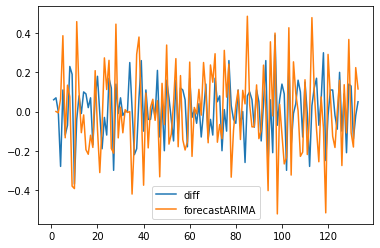

In [752]:
#ARIMA

#fit model
model=ARIMA(data['diff'].dropna(), order=(0,1,2))
model_fit=model.fit()

#model summary
print(model_fit.summary())

#make prediction
data['forecastARIMA'] = model_fit.predict()
data[['diff','forecastARIMA']].plot()

In [749]:
mse=mean_squared_error(data.global_mean_temp[0:-2],data.forecastARIMA.dropna())
print("MSE for MA is:",mse)

MSE for MA is: 0.14726118059230633


In [750]:
mae=mean_absolute_error(data.global_mean_temp[0:-2],data.forecastARIMA.dropna())
print("MAE for MA is:",mae)

MAE for MA is: 0.30145636480679083




---



Applying Auto ARIMA

In [751]:
import pmdarima as pm
model = pm.auto_arima(data.iloc[:,0], start_p=1, start_q=1,test='adf',max_p=3, max_q=3,m=1,d=None,seasonal=False,start_P=0, D=0, trace=True,error_action='ignore',  suppress_warnings=True,stepwise=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-172.662, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-138.203, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-150.647, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-170.641, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-139.692, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-171.777, Time=0.44 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-171.188, Time=0.31 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-173.183, Time=0.16 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-171.195, Time=0.41 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-172.644, Time=0.50 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-168.699, Time=0.09 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 2.533 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  

# Best model:  ARIMA(0,1,2)(0,0,0)[0]

Final Result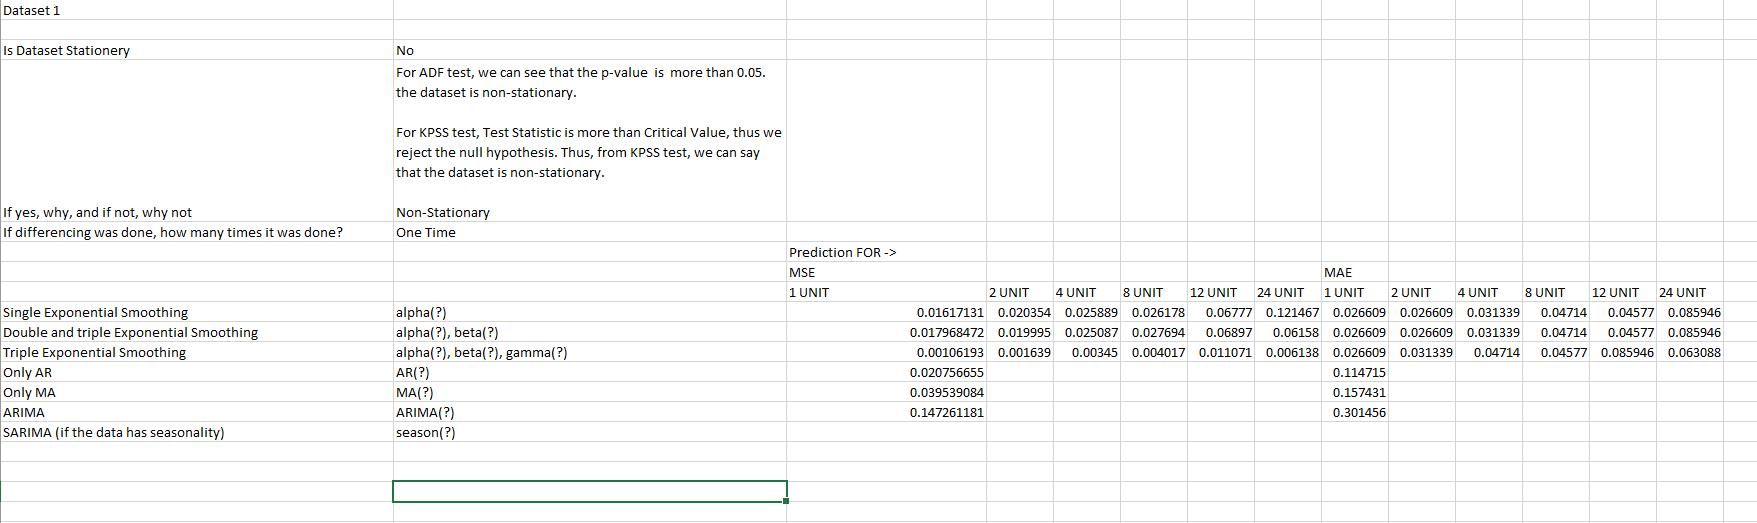